In [1]:
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

import lightgbm as lgb
import pandas as pd
import numpy as np

In [2]:
# image features
df_gvi = pd.read_csv('data/labels/processed/all_imgs_gvi.csv')
df_sky_view_index_wo_abuja = pd.read_csv('data/global-streetscapes/data/segmentation.csv')
df_sky_view_index_abuja = pd.read_csv('data/global-streetscapes/data/abuja_segmentation.csv')
df_sky_view_index_abuja['sky_view_index'] = df_sky_view_index_abuja['Sky'] / df_sky_view_index_abuja['Total'] # original file doesn't have sky view factor computed
df_sky_view_index = pd.concat([df_sky_view_index_wo_abuja[['uuid', 'sky_view_index']], df_sky_view_index_abuja[['uuid', 'sky_view_index']]])

# spatial information
df_spatial_entropy = pd.read_csv('data/labels/processed/spatial_entropy_relative_metrics.csv')
df_shannon_entropy = pd.read_csv('data/labels/processed/shannon_entropy_metrics.csv')
df_proximity = pd.read_csv('data/depth/mean_depth_hist_by_q1q3_qscores.csv', index_col=0) # hard to summarize into one value

# perception q scores
df_singleSVI_multiPar = pd.read_csv('data/labels/processed/singleSVI_multiPar_qscores.csv')
df_multiSVI_singlePar = pd.read_csv('data/labels/processed/multiSVI_SinglePar_qscores.csv')

# metadata
df_metadata = pd.read_csv('data/svi/metadata.csv', index_col=0)
df_metadata = df_metadata.rename(columns={'city': 'svi_from'})


# Load data

## Preprocess datasets

In [3]:
# use all perception indicator, but green is the target variable
df_singleSVI_multiPar['scaled_qscore'] = df_singleSVI_multiPar['Score'] / 10
df_multiSVI_singlePar['scaled_qscore'] = df_multiSVI_singlePar['Score'] / 10

df_multiSVI_singlePar_wide = df_multiSVI_singlePar[['uuid', 'Question', 'participants_from', 'scaled_qscore']]
df_multiSVI_singlePar_wide = df_multiSVI_singlePar_wide.pivot_table(index = ['uuid', 'participants_from'], columns=['Question'], values = 'scaled_qscore')
df_multiSVI_singlePar_wide = df_multiSVI_singlePar_wide.dropna(subset = ['green'])
df_multiSVI_singlePar_wide = df_multiSVI_singlePar_wide.reset_index(drop=False)
df_multiSVI_singlePar_wide

Question,uuid,participants_from,beautiful,boring,cycle,depressing,green,live nearby,lively,safe,walk,wealthy
0,003543b8-c222-4638-8e46-0821f2ff8e13,All,0.537725,0.541711,0.390565,0.499878,0.576511,0.458238,0.361653,0.537028,0.397863,0.575198
1,003543b8-c222-4638-8e46-0821f2ff8e13,Chile,0.761905,0.594949,NaN,NaN,0.666667,0.622222,0.257937,0.809524,NaN,0.741667
2,003543b8-c222-4638-8e46-0821f2ff8e13,Netherlands,0.416667,0.345679,NaN,0.458333,0.582242,0.492593,NaN,NaN,0.296296,0.732804
3,003543b8-c222-4638-8e46-0821f2ff8e13,Singapore,0.675000,NaN,NaN,NaN,0.515873,NaN,NaN,NaN,NaN,NaN
4,003543b8-c222-4638-8e46-0821f2ff8e13,USA,NaN,0.633333,0.354167,0.494048,0.766270,NaN,0.313492,0.477778,NaN,0.627778
...,...,...,...,...,...,...,...,...,...,...,...,...
1898,fef0d6d6-2a3d-4dc1-81eb-d4ee11a50975,USA,0.675926,0.388889,0.333754,0.375000,0.518519,0.464744,0.333333,NaN,0.719577,0.660417
1899,ff03e637-0523-4b6e-af5e-feb2134b2829,All,0.455224,0.393502,0.524514,0.420018,0.416233,0.523485,0.494031,0.517736,0.592295,0.488429
1900,ff03e637-0523-4b6e-af5e-feb2134b2829,Chile,0.574074,0.389506,0.843750,NaN,0.190476,0.517196,NaN,NaN,NaN,0.200000
1901,ff03e637-0523-4b6e-af5e-feb2134b2829,Nigeria,0.460317,0.250000,0.625926,0.391667,0.407407,NaN,0.291667,NaN,0.432804,0.669643


In [4]:
# sky view index
df_features = pd.merge(df_metadata[['uuid', 'svi_from']], df_sky_view_index, how='left', on='uuid')
assert (df_features['sky_view_index'].isna().sum() == 0)

# green view index
df_features = pd.merge(df_features, df_gvi, how='left', on='uuid')
assert (df_features['sky_view_index'].isna().sum() == 0)

# spatial and shannon entropy
df_features = pd.merge(df_features, df_spatial_entropy[['uuid','spatial_045']])
df_features = pd.merge(df_features, df_shannon_entropy)
df_features = df_features.rename(columns={'spatial_045': 'spatial_entropy', 'entropy': 'shannon_entropy'})
df_features

,uuid,svi_from,sky_view_index,green_view_index,spatial_entropy,shannon_entropy
0,dc6eee81-9513-4edb-813b-05b83b5127be,Santiago,0.452324,0.334511,0.924557,2.039815
1,50811b7a-5b0f-4581-92fa-017e6ff26ba0,Santiago,0.050087,0.163249,0.142592,2.494567
2,35c8af9e-5e36-4810-9824-59b9b273fbcf,Santiago,0.259458,0.020650,0.105742,2.314826
3,3a439403-305b-4be7-ba43-f8ff8e75c31c,Santiago,0.349109,0.122725,0.436074,2.302735
4,3cc24150-c590-4d83-883c-44855010e338,Santiago,0.076285,0.293745,0.240625,2.695377
...,...,...,...,...,...,...
395,416a4869-428a-475a-92bd-19f2611b2925,Amsterdam,0.066982,0.167882,0.186094,2.483413
396,dad8c5a5-80cd-4d1e-a3cc-b429cdbb90c2,Amsterdam,0.159384,0.014091,0.014346,2.673296
397,b7abb7f7-7031-4fc9-8f16-7e591dcdfbce,Amsterdam,0.219106,0.044875,0.244008,2.554443
398,41a8b6ce-02df-47e8-b7d1-10cce55b6575,Amsterdam,0.063303,0.301120,0.243865,2.696604


In [5]:
# dataframe for all qscores combined 
df_w_scores_wide = pd.merge(df_multiSVI_singlePar_wide, df_features, how='left', on='uuid')
df_w_scores_wide

,uuid,participants_from,beautiful,boring,cycle,depressing,green,live nearby,lively,safe,walk,wealthy,svi_from,sky_view_index,green_view_index,spatial_entropy,shannon_entropy
0,003543b8-c222-4638-8e46-0821f2ff8e13,All,0.537725,0.541711,0.390565,0.499878,0.576511,0.458238,0.361653,0.537028,0.397863,0.575198,San Francisco,0.192741,0.323400,0.521697,2.819244
1,003543b8-c222-4638-8e46-0821f2ff8e13,Chile,0.761905,0.594949,NaN,NaN,0.666667,0.622222,0.257937,0.809524,NaN,0.741667,San Francisco,0.192741,0.323400,0.521697,2.819244
2,003543b8-c222-4638-8e46-0821f2ff8e13,Netherlands,0.416667,0.345679,NaN,0.458333,0.582242,0.492593,NaN,NaN,0.296296,0.732804,San Francisco,0.192741,0.323400,0.521697,2.819244
3,003543b8-c222-4638-8e46-0821f2ff8e13,Singapore,0.675000,NaN,NaN,NaN,0.515873,NaN,NaN,NaN,NaN,NaN,San Francisco,0.192741,0.323400,0.521697,2.819244
4,003543b8-c222-4638-8e46-0821f2ff8e13,USA,NaN,0.633333,0.354167,0.494048,0.766270,NaN,0.313492,0.477778,NaN,0.627778,San Francisco,0.192741,0.323400,0.521697,2.819244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1898,fef0d6d6-2a3d-4dc1-81eb-d4ee11a50975,USA,0.675926,0.388889,0.333754,0.375000,0.518519,0.464744,0.333333,NaN,0.719577,0.660417,San Francisco,0.066769,0.267376,0.269730,2.569206
1899,ff03e637-0523-4b6e-af5e-feb2134b2829,All,0.455224,0.393502,0.524514,0.420018,0.416233,0.523485,0.494031,0.517736,0.592295,0.488429,Amsterdam,0.022985,0.179655,0.111628,2.721211
1900,ff03e637-0523-4b6e-af5e-feb2134b2829,Chile,0.574074,0.389506,0.843750,NaN,0.190476,0.517196,NaN,NaN,NaN,0.200000,Amsterdam,0.022985,0.179655,0.111628,2.721211
1901,ff03e637-0523-4b6e-af5e-feb2134b2829,Nigeria,0.460317,0.250000,0.625926,0.391667,0.407407,NaN,0.291667,NaN,0.432804,0.669643,Amsterdam,0.022985,0.179655,0.111628,2.721211


In [6]:
# create rows with svi_from == All
aux_df = df_w_scores_wide.copy()
aux_df.loc[:, 'svi_from'] = 'All'
df_w_scores_wide_full = pd.concat([df_w_scores_wide, aux_df], ignore_index=True)
df_w_scores_wide_full

,uuid,participants_from,beautiful,boring,cycle,depressing,green,live nearby,lively,safe,walk,wealthy,svi_from,sky_view_index,green_view_index,spatial_entropy,shannon_entropy
0,003543b8-c222-4638-8e46-0821f2ff8e13,All,0.537725,0.541711,0.390565,0.499878,0.576511,0.458238,0.361653,0.537028,0.397863,0.575198,San Francisco,0.192741,0.323400,0.521697,2.819244
1,003543b8-c222-4638-8e46-0821f2ff8e13,Chile,0.761905,0.594949,NaN,NaN,0.666667,0.622222,0.257937,0.809524,NaN,0.741667,San Francisco,0.192741,0.323400,0.521697,2.819244
2,003543b8-c222-4638-8e46-0821f2ff8e13,Netherlands,0.416667,0.345679,NaN,0.458333,0.582242,0.492593,NaN,NaN,0.296296,0.732804,San Francisco,0.192741,0.323400,0.521697,2.819244
3,003543b8-c222-4638-8e46-0821f2ff8e13,Singapore,0.675000,NaN,NaN,NaN,0.515873,NaN,NaN,NaN,NaN,NaN,San Francisco,0.192741,0.323400,0.521697,2.819244
4,003543b8-c222-4638-8e46-0821f2ff8e13,USA,NaN,0.633333,0.354167,0.494048,0.766270,NaN,0.313492,0.477778,NaN,0.627778,San Francisco,0.192741,0.323400,0.521697,2.819244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3801,fef0d6d6-2a3d-4dc1-81eb-d4ee11a50975,USA,0.675926,0.388889,0.333754,0.375000,0.518519,0.464744,0.333333,NaN,0.719577,0.660417,All,0.066769,0.267376,0.269730,2.569206
3802,ff03e637-0523-4b6e-af5e-feb2134b2829,All,0.455224,0.393502,0.524514,0.420018,0.416233,0.523485,0.494031,0.517736,0.592295,0.488429,All,0.022985,0.179655,0.111628,2.721211
3803,ff03e637-0523-4b6e-af5e-feb2134b2829,Chile,0.574074,0.389506,0.843750,NaN,0.190476,0.517196,NaN,NaN,NaN,0.200000,All,0.022985,0.179655,0.111628,2.721211
3804,ff03e637-0523-4b6e-af5e-feb2134b2829,Nigeria,0.460317,0.250000,0.625926,0.391667,0.407407,NaN,0.291667,NaN,0.432804,0.669643,All,0.022985,0.179655,0.111628,2.721211


In [7]:
df_w_scores_wide.groupby("participants_from").count()

,uuid,beautiful,boring,cycle,depressing,green,live nearby,lively,safe,walk,wealthy,svi_from,sky_view_index,green_view_index,spatial_entropy,shannon_entropy
participants_from,,,,,,,,,,,,,,,,
All,400,400,400,400,400,400,400,400,400,400,400,400,400,400,400,400
Chile,303,229,230,208,228,303,217,219,223,234,231,303,303,303,303,303
Netherlands,306,233,223,217,226,306,220,227,228,218,233,306,306,306,306,306
Nigeria,298,218,224,216,217,298,222,220,222,218,242,298,298,298,298,298
Singapore,299,233,215,206,224,299,208,218,217,213,230,299,299,299,299,299
USA,297,229,231,203,206,297,218,224,213,219,223,297,297,297,297,297


In [8]:
df_w_scores_wide_full.groupby("participants_from").count() # number of unique images 400 x 2, (80 x (5 + 1 places))

,uuid,beautiful,boring,cycle,depressing,green,live nearby,lively,safe,walk,wealthy,svi_from,sky_view_index,green_view_index,spatial_entropy,shannon_entropy
participants_from,,,,,,,,,,,,,,,,
All,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800,800
Chile,606,458,460,416,456,606,434,438,446,468,462,606,606,606,606,606
Netherlands,612,466,446,434,452,612,440,454,456,436,466,612,612,612,612,612
Nigeria,596,436,448,432,434,596,444,440,444,436,484,596,596,596,596,596
Singapore,598,466,430,412,448,598,416,436,434,426,460,598,598,598,598,598
USA,594,458,462,406,412,594,436,448,426,438,446,594,594,594,594,594


# Helper functions

In [9]:
def create_stratification_column(df):
    """Create a stratification column based on combinations of svi_from and participants_from"""
    df['strat_column'] = df['svi_from'].astype(str) + '_' + df['participants_from'].astype(str)
    return df

def stratified_train_test_split(df, test_size=0.2, random_state=42):
    """
    Perform stratified train-test split ensuring equal representation 
    of svi_from and participants_from combinations in test set
    """
    # Create stratification column
    df = create_stratification_column(df)
    
    # Features and target
    X = df.drop(['green', 'strat_column'], axis=1)
    y = df['green']
    
    # Stratified split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=test_size, 
        stratify=df['strat_column'],
        random_state=random_state
    )
    
    return X_train, X_test, y_train, y_test

# Model functions 

## Random Forest

In [10]:
def hyperparameter_tuning_rf(X_train, y_train, cv_folds=5, random_state=42, n_iter=50):
    """
    Randomized hyperparameter tuning for Random Forest regression, stratified by
    (svi_from, participants_from) combinations
    """
    # Recreate stratification labels for CV
    strat_labels = X_train['svi_from'].astype(str) + "_" + X_train['participants_from'].astype(str)
    
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state)
    
    # Parameter distributions
    param_dist = {
        'n_estimators': np.arange(100, 500, 50),
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None]
    }
    
    rf = RandomForestRegressor(random_state=random_state, n_jobs=-1)
    
    # Randomized search with stratified CV
    rand_rf = RandomizedSearchCV(
        rf,
        param_distributions=param_dist,
        n_iter=n_iter,
        cv=skf.split(X_train, strat_labels),
        scoring='neg_mean_squared_error',
        random_state=random_state,
        n_jobs=-1,
        verbose=1
    )
    
    print("Starting Random Forest hyperparameter tuning...")
    # remove svi_from
    X_train = X_train.drop(['svi_from'], axis=1)
    rand_rf.fit(X_train, y_train)
    
    return rand_rf.best_estimator_, rand_rf.best_params_, rand_rf.best_score_

## LightGBM

In [11]:
def hyperparameter_tuning_lgb(X_train, y_train, cv_folds=5, random_state=42, n_iter=50):
    """
    Randomized hyperparameter tuning for LightGBM, stratified by
    (svi_from, participants_from) combinations
    """

    # Recreate stratification labels for CV
    strat_labels = X_train['svi_from'].astype(str) + "_" + X_train['participants_from'].astype(str)

    # Stratified CV
    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state)

    # Initialize model
    lgb_reg = lgb.LGBMRegressor(random_state=random_state, verbose=-1)

    # Define parameter distribution
    param_dist_lgb = {
        'n_estimators': [100, 200, 300, 500],
        'max_depth': [10, 20, 30, -1],  # -1 = no limit
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'num_leaves': [31, 50, 100, 200],
        'min_child_samples': [10, 20, 30, 50],
        'subsample': [0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.7, 0.8, 0.9, 1.0]
    }

    # RandomizedSearchCV
    rand_lgb = RandomizedSearchCV(
        estimator=lgb_reg,
        param_distributions=param_dist_lgb,
        n_iter=n_iter,
        scoring='neg_mean_squared_error',
        cv=skf.split(X_train, strat_labels),
        random_state=random_state,
        n_jobs=-1,
        verbose=0
    )

    print(f"Starting LightGBM hyperparameter tuning ...")
    # remove svi_from
    X_train = X_train.drop(['svi_from'], axis=1)
    rand_lgb.fit(X_train, y_train)

    return rand_lgb.best_estimator_, rand_lgb.best_params_, rand_lgb.best_score_

# Evaluation functions

In [12]:
def evaluate_model(model, X_test, y_test, model_name):
    """Evaluate model performance"""
    
    # remove svi_from
    X_test = X_test.drop(['svi_from'], axis=1)
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"\n{model_name} Performance:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
    
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}


# Data preparation

In [13]:
# remove uuid
df_all_scores = df_w_scores_wide.drop(['uuid'], axis=1)
#df_all_scores = df_w_scores_wide_full.drop('uuid', axis=1)

# encode string features
locations_map = {
    'All': 0,
    'Chile': 1,
    'Netherlands': 2,
    'Nigeria': 3,
    'Singapore': 4,
    'USA': 5,
    'Santiago': 1,
    'Amsterdam': 2,
    'Abuja': 3,
    'Singapore': 4, 
    'San Francisco': 5
}

# apply encoding
df_all_scores['svi_from'] = df_all_scores['svi_from'].replace(locations_map)
df_all_scores['participants_from'] = df_all_scores['participants_from'].replace(locations_map)

# TODO: remove combined instance (All), not used in the end
#df_all_scores = df_all_scores[df_all_scores['participants_from'] != 0]

print(df_all_scores['participants_from'].unique())
print(df_all_scores['svi_from'].unique())

df_all_scores

[0 1 2 4 5 3]
[5 2 4 1 3]


/var/folders/kw/9lnn_1r159n28p1krywmf8_w0000gq/T/ipykernel_70335/2951011785.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_all_scores['svi_from'] = df_all_scores['svi_from'].replace(locations_map)
/var/folders/kw/9lnn_1r159n28p1krywmf8_w0000gq/T/ipykernel_70335/2951011785.py:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_all_scores['participants_from'] = df_all_scores['participants_from'].replace(locations_map)


,participants_from,beautiful,boring,cycle,depressing,green,live nearby,lively,safe,walk,wealthy,svi_from,sky_view_index,green_view_index,spatial_entropy,shannon_entropy
0,0,0.537725,0.541711,0.390565,0.499878,0.576511,0.458238,0.361653,0.537028,0.397863,0.575198,5,0.192741,0.323400,0.521697,2.819244
1,1,0.761905,0.594949,NaN,NaN,0.666667,0.622222,0.257937,0.809524,NaN,0.741667,5,0.192741,0.323400,0.521697,2.819244
2,2,0.416667,0.345679,NaN,0.458333,0.582242,0.492593,NaN,NaN,0.296296,0.732804,5,0.192741,0.323400,0.521697,2.819244
3,4,0.675000,NaN,NaN,NaN,0.515873,NaN,NaN,NaN,NaN,NaN,5,0.192741,0.323400,0.521697,2.819244
4,5,NaN,0.633333,0.354167,0.494048,0.766270,NaN,0.313492,0.477778,NaN,0.627778,5,0.192741,0.323400,0.521697,2.819244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1898,5,0.675926,0.388889,0.333754,0.375000,0.518519,0.464744,0.333333,NaN,0.719577,0.660417,5,0.066769,0.267376,0.269730,2.569206
1899,0,0.455224,0.393502,0.524514,0.420018,0.416233,0.523485,0.494031,0.517736,0.592295,0.488429,2,0.022985,0.179655,0.111628,2.721211
1900,1,0.574074,0.389506,0.843750,NaN,0.190476,0.517196,NaN,NaN,NaN,0.200000,2,0.022985,0.179655,0.111628,2.721211
1901,3,0.460317,0.250000,0.625926,0.391667,0.407407,NaN,0.291667,NaN,0.432804,0.669643,2,0.022985,0.179655,0.111628,2.721211


In [14]:
# stratified train-test split (80-20)
X_train, X_test, y_train, y_test = stratified_train_test_split(df_all_scores)
    
print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
    
# check stratification worked
#train_df_check = X_train.copy()
#train_df_check['strat'] = train_df_check['svi_from'].astype(str) + '_' + train_df_check['participants_from'].astype(str)
    
#test_df_check = X_test.copy()
#test_df_check['strat'] = test_df_check['svi_from'].astype(str) + '_' + test_df_check['participants_from'].astype(str)
    
#print("\nStratification check - Train set combinations:")
#print(train_df_check['strat'].value_counts().sort_index())
#print("\nStratification check - Test set combinations:")
#print(test_df_check['strat'].value_counts().sort_index())
    

Training set size: 1522
Test set size: 381


# Model training

In [15]:
# hyperparameter tuning with 5-fold CV
# random forest    
best_rf, best_params_rf, best_score_rf = hyperparameter_tuning_rf(X_train, y_train)
print(f"Best RF parameters: {best_params_rf}")
print(f"Best RF CV score (neg_MSE): {best_score_rf:.4f}")
    
print("\n")

# lightGBM
best_lgb, best_params_lgb, best_score_lgb = hyperparameter_tuning_lgb(X_train, y_train)
print(f"Best LightGBM parameters: {best_params_lgb}")
print(f"Best LightGBM CV score (neg_MSE): {best_score_lgb:.4f}")
    

Starting Random Forest hyperparameter tuning...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best RF parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': None}
Best RF CV score (neg_MSE): -0.0187


Starting LightGBM hyperparameter tuning ...
Best LightGBM parameters: {'subsample': 0.7, 'num_leaves': 200, 'n_estimators': 200, 'min_child_samples': 20, 'max_depth': -1, 'learning_rate': 0.01, 'colsample_bytree': 0.7}
Best LightGBM CV score (neg_MSE): -0.0190


# Model evaluation

In [16]:
# evaluate on test set
print("Evaluating models on test set...")
rf_results = evaluate_model(best_rf, X_test, y_test, "Random Forest")
lgb_results = evaluate_model(best_lgb, X_test, y_test, "LightGBM")
    
# compare models
if best_score_rf > best_score_lgb:  # Remember: neg_MSE, so higher is better
    print("Random Forest performed better in cross-validation")
    best_model = best_rf
    best_model_name = "Random Forest"
else:
    print("LightGBM performed better in cross-validation")
    best_model = best_lgb
    best_model_name = "LightGBM"
    
print(f"Best overall model: {best_model_name}")

Evaluating models on test set...

Random Forest Performance:
MSE: 0.0191
RMSE: 0.1381
MAE: 0.1067
R²: 0.4928

LightGBM Performance:
MSE: 0.0203
RMSE: 0.1425
MAE: 0.1099
R²: 0.4603
Random Forest performed better in cross-validation
Best overall model: Random Forest


In [17]:
best_rf.get_params() 


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 200,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

# Feature Importance

In [18]:
def analyze_feature_importance(model, X_train, X_test, y_test, model_name, feature_names=None):
    """
    Comprehensive feature importance analysis for tree-based models
    """
    
    X_train = X_train.drop('svi_from', axis=1)
    X_test = X_test.drop('svi_from', axis=1)

    if feature_names is None:
        feature_names = X_train.columns if hasattr(X_train, 'columns') else [f'feature_{i}' for i in range(X_train.shape[1])]
    
    print(f"\n=== FEATURE IMPORTANCE ANALYSIS - {model_name} ===\n")
    
    importance_results = {}
    
    # 1. Built-in Feature Importance (Gini/Gain-based)
    if hasattr(model, 'feature_importances_'):
        builtin_importance = model.feature_importances_
        importance_results['builtin'] = pd.DataFrame({
            'feature': feature_names,
            'importance': builtin_importance
        }).sort_values('importance', ascending=False)
        
        print("1. Built-in Feature Importance (Gini/Gain-based):")
        print("=" * 50)
        for i, row in importance_results['builtin'].head(10).iterrows():
            print(f"{row['feature']:20s}: {row['importance']:.4f}")
        
    # 2. Permutation Importance (more reliable)
    print(f"\n2. Permutation Importance (on test set):")
    print("=" * 50)
    perm_importance = permutation_importance(
        model, X_test, y_test, 
        n_repeats=10, 
        random_state=42,
        scoring='neg_mean_squared_error'
    )
    
    importance_results['permutation'] = pd.DataFrame({
        'feature': feature_names,
        'importance_mean': perm_importance.importances_mean,
        'importance_std': perm_importance.importances_std
    }).sort_values('importance_mean', ascending=False)
    
    for i, row in importance_results['permutation'].head(10).iterrows():
        print(f"{row['feature']:20s}: {row['importance_mean']:.4f} (+/- {row['importance_std']:.4f})")
    
    # 3. Feature Importance Summary
    print(f"\n3. TOP 5 MOST IMPORTANT FEATURES:")
    print("=" * 50)
    top_features_perm = importance_results['permutation'].head(5)
    for i, (_, row) in enumerate(top_features_perm.iterrows(), 1):
        print(f"{i}. {row['feature']:20s}: {row['importance_mean']:.4f}")
    
    return importance_results

def plot_feature_importance(importance_results, model_name, top_n=10):
    """
    Create visualizations for feature importance
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Built-in importance
    if 'builtin' in importance_results:
        builtin_top = importance_results['builtin'].head(top_n)
        axes[0].barh(range(len(builtin_top)), builtin_top['importance'][::-1])
        axes[0].set_yticks(range(len(builtin_top)))
        axes[0].set_yticklabels(builtin_top['feature'][::-1])
        axes[0].set_xlabel('Importance')
        axes[0].set_title(f'{model_name}: Built-in Feature Importance')
        axes[0].grid(axis='x', alpha=0.3)
    
    # Plot 2: Permutation importance with error bars
    perm_top = importance_results['permutation'].head(top_n)
    axes[1].barh(range(len(perm_top)), perm_top['importance_mean'][::-1], 
                xerr=perm_top['importance_std'][::-1], capsize=5)
    axes[1].set_yticks(range(len(perm_top)))
    axes[1].set_yticklabels(perm_top['feature'][::-1])
    axes[1].set_xlabel('Permutation Importance')
    axes[1].set_title(f'{model_name}: Permutation Feature Importance')
    axes[1].grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def compare_feature_importance_across_models(results):
    """
    Compare feature importance across Random Forest and LightGBM
    """
    print("\n=== FEATURE IMPORTANCE COMPARISON ACROSS MODELS ===\n")
    
    # Get permutation importance from both models
    rf_importance = results['rf_importance']['permutation'][['feature', 'importance_mean']].copy()
    rf_importance.columns = ['feature', 'rf_importance']
    
    lgb_importance = results['lgb_importance']['permutation'][['feature', 'importance_mean']].copy()
    lgb_importance.columns = ['feature', 'lgb_importance']
    
    # Merge and compare
    comparison = pd.merge(rf_importance, lgb_importance, on='feature', how='outer').fillna(0)
    comparison['avg_importance'] = (comparison['rf_importance'] + comparison['lgb_importance']) / 2
    comparison = comparison.sort_values('avg_importance', ascending=False)
    
    print("Feature importance comparison (Permutation-based):")
    print("=" * 70)
    print(f"{'Feature':<20} {'Random Forest':<15} {'LightGBM':<15} {'Average':<15}")
    print("-" * 70)
    
    for _, row in comparison.head(10).iterrows():
        print(f"{row['feature']:<20} {row['rf_importance']:<15.4f} {row['lgb_importance']:<15.4f} {row['avg_importance']:<15.4f}")
    
    # Plot comparison
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    x = range(len(comparison.head(10)))
    width = 0.35
    
    ax.barh([i - width/2 for i in x], comparison.head(10)['rf_importance'], 
           width, label='Random Forest', alpha=0.8)
    ax.barh([i + width/2 for i in x], comparison.head(10)['lgb_importance'], 
           width, label='LightGBM', alpha=0.8)
    
    ax.set_yticks(x)
    ax.set_yticklabels(comparison.head(10)['feature'])
    ax.set_xlabel('Feature Importance')
    ax.set_title('Feature Importance Comparison: Random Forest vs LightGBM')
    ax.legend()
    ax.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return comparison



=== FEATURE IMPORTANCE ANALYSIS - Random Forest ===

1. Built-in Feature Importance (Gini/Gain-based):
green_view_index    : 0.3385
spatial_entropy     : 0.1248
shannon_entropy     : 0.0579
safe                : 0.0521
sky_view_index      : 0.0520
live nearby         : 0.0484
wealthy             : 0.0482
beautiful           : 0.0472
walk                : 0.0468
cycle               : 0.0450

2. Permutation Importance (on test set):
green_view_index    : 0.0145 (+/- 0.0012)
spatial_entropy     : 0.0065 (+/- 0.0008)
shannon_entropy     : 0.0019 (+/- 0.0003)
sky_view_index      : 0.0013 (+/- 0.0001)
safe                : 0.0008 (+/- 0.0003)
live nearby         : 0.0004 (+/- 0.0002)
beautiful           : 0.0003 (+/- 0.0001)
walk                : 0.0003 (+/- 0.0002)
cycle               : 0.0002 (+/- 0.0001)
wealthy             : 0.0002 (+/- 0.0002)

3. TOP 5 MOST IMPORTANT FEATURES:
1. green_view_index    : 0.0145
2. spatial_entropy     : 0.0065
3. shannon_entropy     : 0.0019
4. sky_view_i

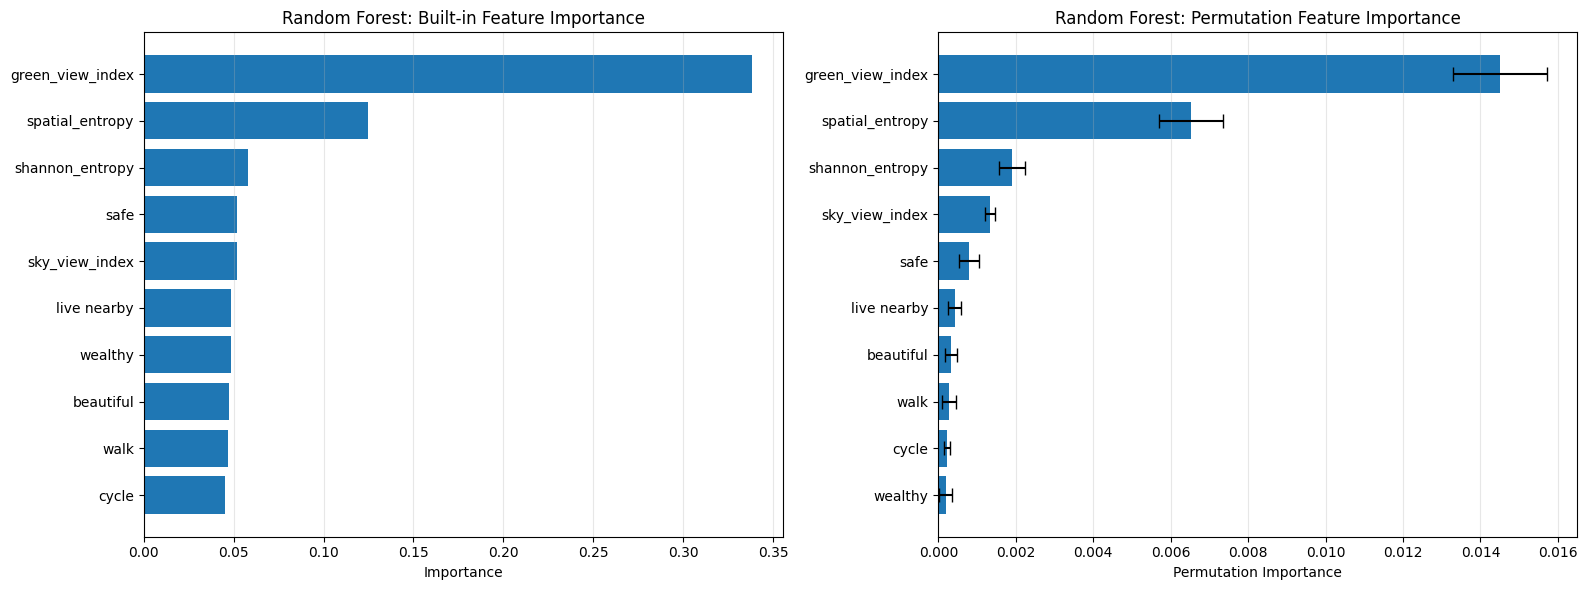


=== FEATURE IMPORTANCE ANALYSIS - LightGBM ===

1. Built-in Feature Importance (Gini/Gain-based):
safe                : 961.0000
live nearby         : 943.0000
green_view_index    : 941.0000
sky_view_index      : 936.0000
wealthy             : 919.0000
beautiful           : 912.0000
spatial_entropy     : 889.0000
lively              : 883.0000
shannon_entropy     : 866.0000
cycle               : 811.0000

2. Permutation Importance (on test set):
green_view_index    : 0.0103 (+/- 0.0012)
spatial_entropy     : 0.0065 (+/- 0.0007)
shannon_entropy     : 0.0019 (+/- 0.0003)
sky_view_index      : 0.0015 (+/- 0.0001)
safe                : 0.0009 (+/- 0.0003)
live nearby         : 0.0003 (+/- 0.0002)
walk                : 0.0003 (+/- 0.0001)
beautiful           : 0.0002 (+/- 0.0001)
wealthy             : 0.0002 (+/- 0.0002)
depressing          : 0.0001 (+/- 0.0001)

3. TOP 5 MOST IMPORTANT FEATURES:
1. green_view_index    : 0.0103
2. spatial_entropy     : 0.0065
3. shannon_entropy     : 0.001

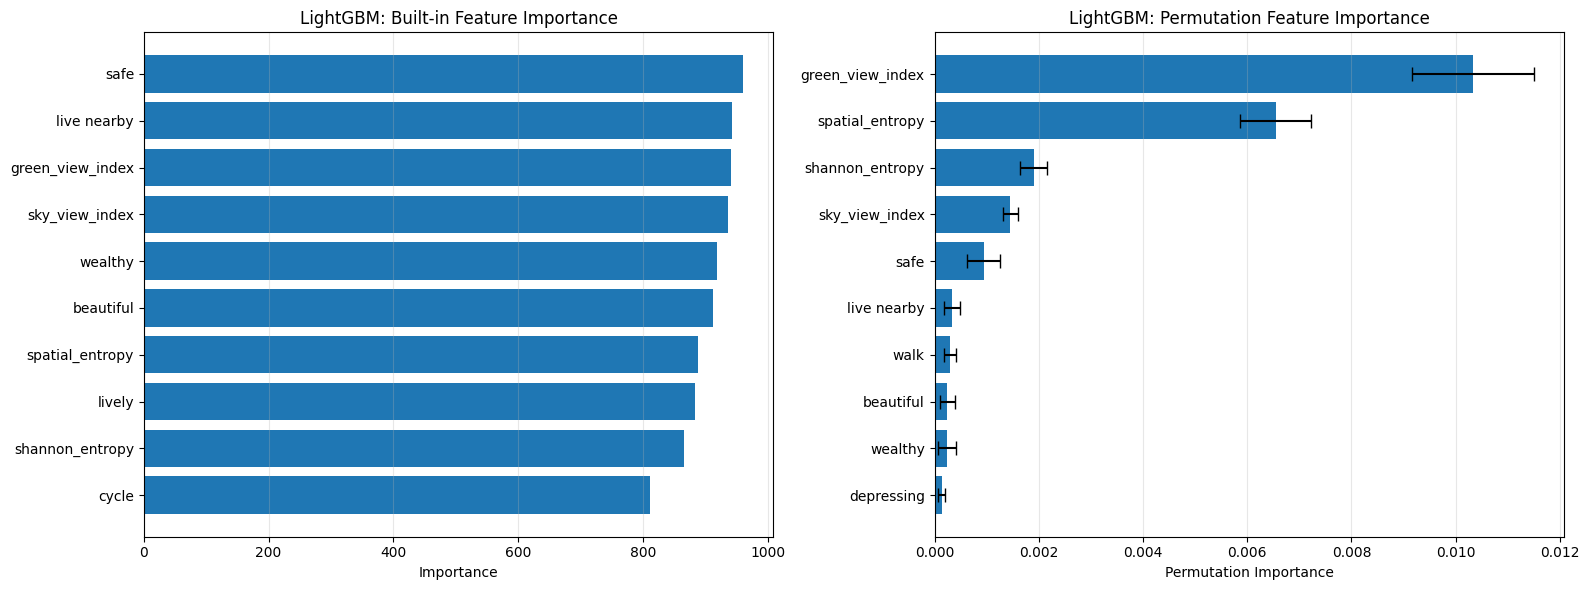


=== FEATURE IMPORTANCE COMPARISON ACROSS MODELS ===

Feature importance comparison (Permutation-based):
Feature              Random Forest   LightGBM        Average        
----------------------------------------------------------------------
green_view_index     0.0145          0.0103          0.0124         
spatial_entropy      0.0065          0.0065          0.0065         
shannon_entropy      0.0019          0.0019          0.0019         
sky_view_index       0.0013          0.0015          0.0014         
safe                 0.0008          0.0009          0.0009         
live nearby          0.0004          0.0003          0.0004         
beautiful            0.0003          0.0002          0.0003         
walk                 0.0003          0.0003          0.0003         
wealthy              0.0002          0.0002          0.0002         
cycle                0.0002          0.0001          0.0001         


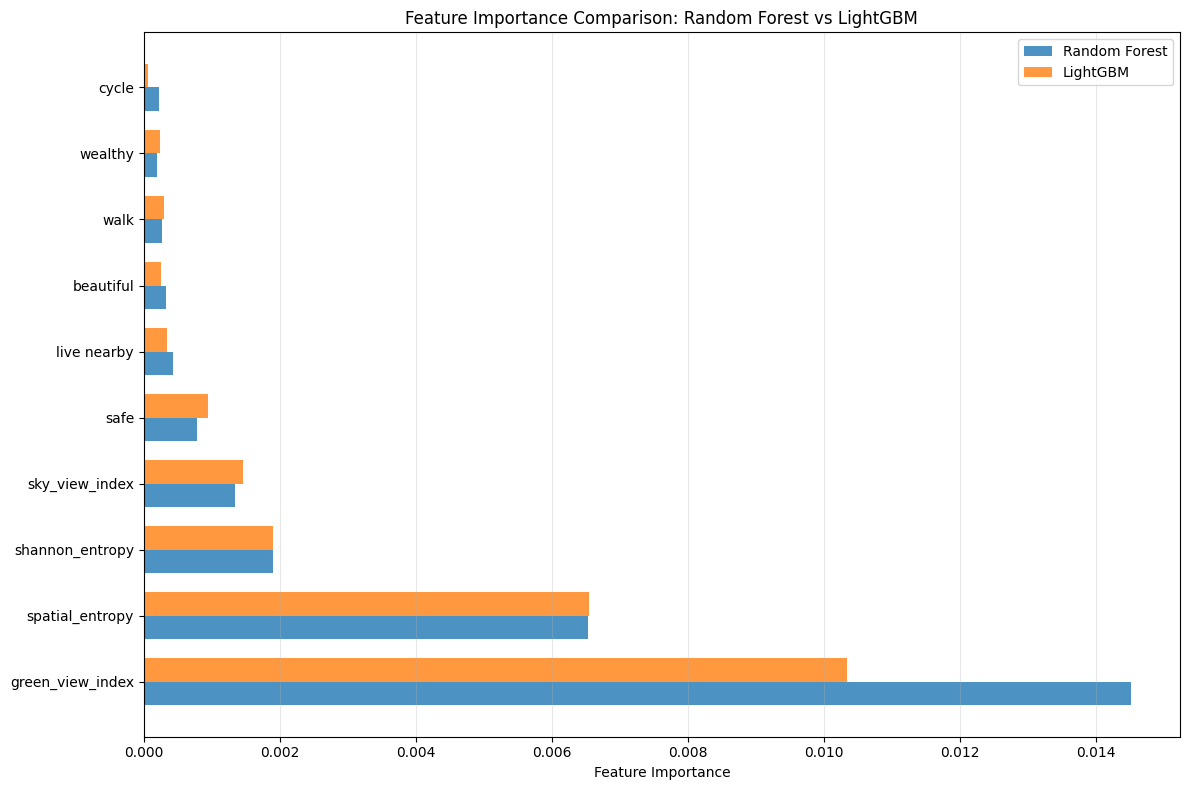

In [19]:
rf_importance = None
lgb_importance = None
feature_comparison = None
    
# Get feature names (handle encoded categorical variables)
feature_names = list(X_train.columns) if hasattr(X_train, 'columns') else [f'feature_{i}' for i in range(X_train.shape[1])]
feature_names = feature_names.remove('svi_from')       

# Random Forest importance
rf_importance = analyze_feature_importance(best_rf, X_train, X_test, y_test, "Random Forest", feature_names)
plot_feature_importance(rf_importance, "Random Forest")
# save results
rf_importance['permutation'].to_csv('data/model/rf_permutation_importance.csv', index=False)

# LightGBM importance  
lgb_importance = analyze_feature_importance(best_lgb, X_train, X_test, y_test, "LightGBM", feature_names)
plot_feature_importance(lgb_importance, "LightGBM")
lgb_importance['permutation'].to_csv('data/model/lgb_permutation_importance.csv', index=False)

# Compare across models
results_for_comparison = {
'rf_importance': rf_importance,
'lgb_importance': lgb_importance
}

feature_comparison = compare_feature_importance_across_models(results_for_comparison)


In [20]:
rf_importance

{'builtin':               feature  importance
 11   green_view_index    0.338527
 12    spatial_entropy    0.124822
 13    shannon_entropy    0.057890
 7                safe    0.052097
 10     sky_view_index    0.051980
 5         live nearby    0.048439
 9             wealthy    0.048249
 1           beautiful    0.047199
 8                walk    0.046792
 3               cycle    0.045015
 6              lively    0.043743
 4          depressing    0.042916
 2              boring    0.039807
 0   participants_from    0.012526,
 'permutation':               feature  importance_mean  importance_std
 11   green_view_index         0.014506        0.001209
 12    spatial_entropy         0.006526        0.000815
 13    shannon_entropy         0.001905        0.000333
 10     sky_view_index         0.001337        0.000129
 7                safe         0.000784        0.000258
 5         live nearby         0.000422        0.000163
 1           beautiful         0.000327        0.000147


In [21]:
lgb_importance

{'builtin':               feature  importance
 7                safe         961
 5         live nearby         943
 11   green_view_index         941
 10     sky_view_index         936
 9             wealthy         919
 1           beautiful         912
 12    spatial_entropy         889
 6              lively         883
 13    shannon_entropy         866
 3               cycle         811
 8                walk         789
 4          depressing         710
 2              boring         691
 0   participants_from         260,
 'permutation':               feature  importance_mean  importance_std
 11   green_view_index         0.010333        0.001171
 12    spatial_entropy         0.006543        0.000683
 13    shannon_entropy         0.001900        0.000262
 10     sky_view_index         0.001457        0.000143
 7                safe         0.000940        0.000317
 5         live nearby         0.000333        0.000160
 8                walk         0.000300        0.000117


# Conditional Feature importance

In [22]:
def conditional_permutation_importance(model, X, y, corr_threshold=0.5, n_repeats=10):
    """
    Conditional permutation importance based on Strobl et al. (2008).
    For each feature:
      - Identify correlated features
      - Bin correlated features
      - Permute only within bins (conditional permutation)
    """

    baseline_mse = mean_squared_error(y, model.predict(X))
    feature_names = X.columns
    X = X.copy()
    
    # Compute correlation matrix
    corr = X.corr().abs()

    results = {}

    for feature in feature_names:
        # Find features correlated with this feature
        correlated = corr.index[corr[feature] > corr_threshold].tolist()
        correlated.remove(feature) if feature in correlated else None
        
        if len(correlated) == 0:
            # If no correlated features, fallback to normal permutation
            correlated = None

        scores = []

        for _ in range(n_repeats):
            X_perm = X.copy()

            if correlated is None:
                # Simple permutation
                X_perm[feature] = np.random.permutation(X_perm[feature])
            else:
                # Conditional permutation: permute within bins of correlated features
                # Bin correlated variables (equal-width bins)
                bins = pd.qcut(X_perm[correlated].mean(axis=1), q=10, duplicates='drop')

                for b in bins.unique():
                    idx = (bins == b).values
                    X_perm.loc[idx, feature] = np.random.permutation(X_perm.loc[idx, feature])

            mse_perm = mean_squared_error(y, model.predict(X_perm))
            scores.append(mse_perm - baseline_mse)

        results[feature] = {
            "cpi_mean": np.mean(scores),
            "cpi_std": np.std(scores)
        }

    # Convert to dataframe
    cpi_df = pd.DataFrame([
        {"feature": feat, 
         "importance_mean": vals["cpi_mean"], 
         "importance_std": vals["cpi_std"]}
        for feat, vals in results.items()
    ])

    return cpi_df.sort_values("importance_mean", ascending=False)

def analyze_conditional_feature_importance(model, X_train, X_test, y_test, model_name, feature_names=None):
    
    X_train = X_train.drop('svi_from', axis=1)
    X_test = X_test.drop('svi_from', axis=1)

    if feature_names is None:
        feature_names = X_train.columns
    
    print(f"\n=== FEATURE IMPORTANCE ANALYSIS - {model_name} ===\n")
    
    importance_results = {}
    
    # 1. Built-in importance
    if hasattr(model, 'feature_importances_'):
        builtin_importance = model.feature_importances_
        importance_results['builtin'] = pd.DataFrame({
            'feature': feature_names,
            'importance': builtin_importance
        }).sort_values('importance', ascending=False)
    
    # 2. Standard Permutation Importance
    perm_importance = permutation_importance(
        model, X_test, y_test, 
        n_repeats=10,
        scoring='neg_mean_squared_error',
        random_state=42
    )
    importance_results['permutation'] = pd.DataFrame({
        'feature': feature_names,
        'importance_mean': perm_importance.importances_mean,
        'importance_std': perm_importance.importances_std
    }).sort_values("importance_mean", ascending=False)

    # 3. Conditional Permutation Importance
    print("\n3. Conditional Permutation Importance)")
    print("=" * 70)
    
    cpi_df = conditional_permutation_importance(
        model, X_test, y_test,
        corr_threshold=0.5,
        n_repeats=10
    )
    importance_results["conditional_permutation"] = cpi_df
    
    for _, row in cpi_df.head(10).iterrows():
        print(f"{row['feature']:20s}: {row['importance_mean']:.4f} (+/- {row['importance_std']:.4f})")
    
    return importance_results


=== FEATURE IMPORTANCE ANALYSIS - Random Forest ===


3. Conditional Permutation Importance)
green_view_index    : 0.0086 (+/- 0.0005)
spatial_entropy     : 0.0044 (+/- 0.0005)
shannon_entropy     : 0.0014 (+/- 0.0003)
sky_view_index      : 0.0010 (+/- 0.0002)
safe                : 0.0007 (+/- 0.0002)
live nearby         : 0.0004 (+/- 0.0002)
beautiful           : 0.0004 (+/- 0.0002)
walk                : 0.0003 (+/- 0.0001)
cycle               : 0.0002 (+/- 0.0001)
wealthy             : 0.0001 (+/- 0.0002)


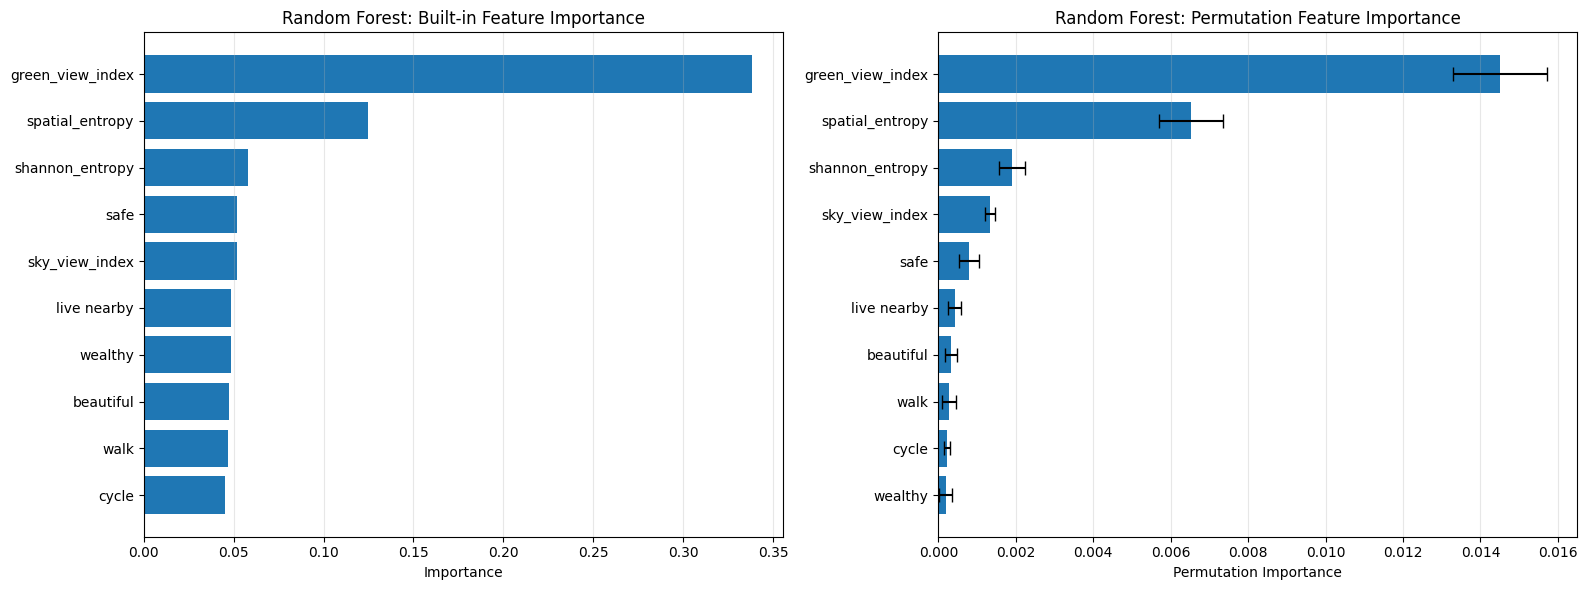


=== FEATURE IMPORTANCE ANALYSIS - LightGBM ===


3. Conditional Permutation Importance)
green_view_index    : 0.0055 (+/- 0.0009)
spatial_entropy     : 0.0034 (+/- 0.0003)
shannon_entropy     : 0.0012 (+/- 0.0003)
sky_view_index      : 0.0011 (+/- 0.0003)
safe                : 0.0009 (+/- 0.0002)
live nearby         : 0.0004 (+/- 0.0001)
beautiful           : 0.0002 (+/- 0.0002)
walk                : 0.0002 (+/- 0.0001)
wealthy             : 0.0002 (+/- 0.0001)
depressing          : 0.0001 (+/- 0.0001)


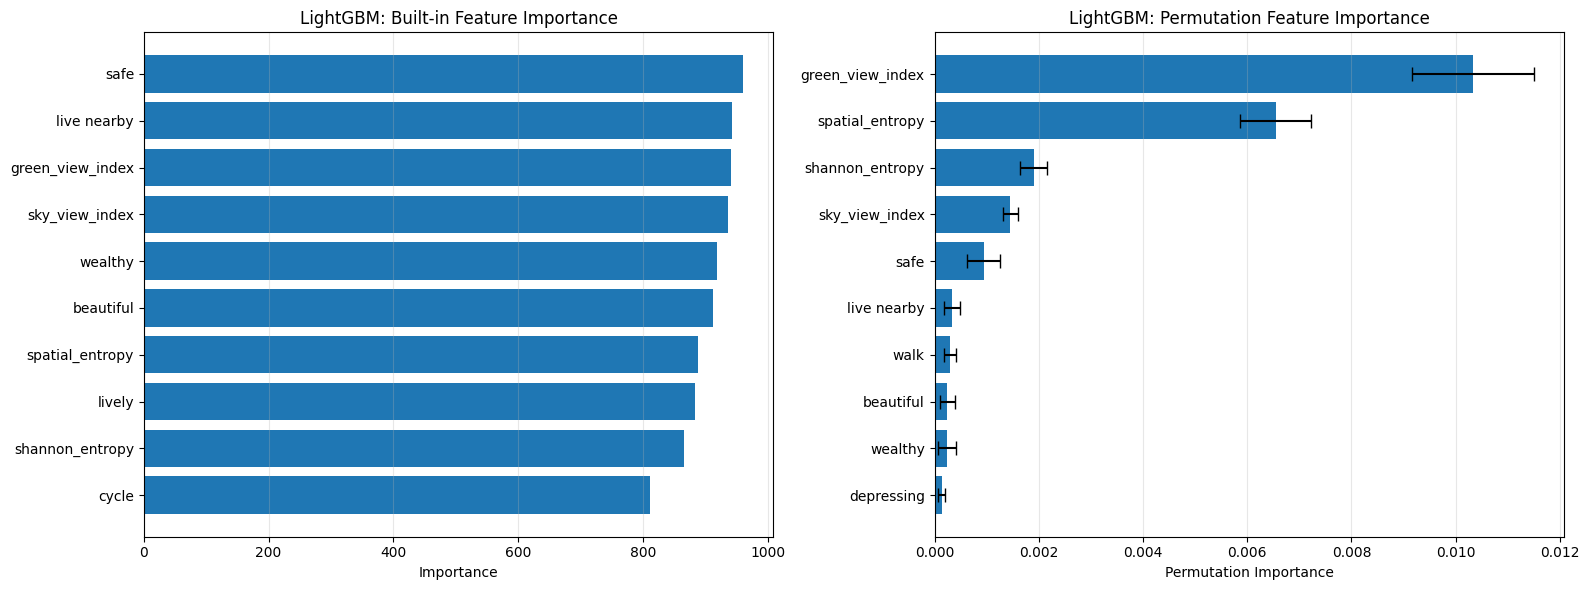


=== FEATURE IMPORTANCE COMPARISON ACROSS MODELS ===

Feature importance comparison (Permutation-based):
Feature              Random Forest   LightGBM        Average        
----------------------------------------------------------------------
green_view_index     0.0145          0.0103          0.0124         
spatial_entropy      0.0065          0.0065          0.0065         
shannon_entropy      0.0019          0.0019          0.0019         
sky_view_index       0.0013          0.0015          0.0014         
safe                 0.0008          0.0009          0.0009         
live nearby          0.0004          0.0003          0.0004         
beautiful            0.0003          0.0002          0.0003         
walk                 0.0003          0.0003          0.0003         
wealthy              0.0002          0.0002          0.0002         
cycle                0.0002          0.0001          0.0001         


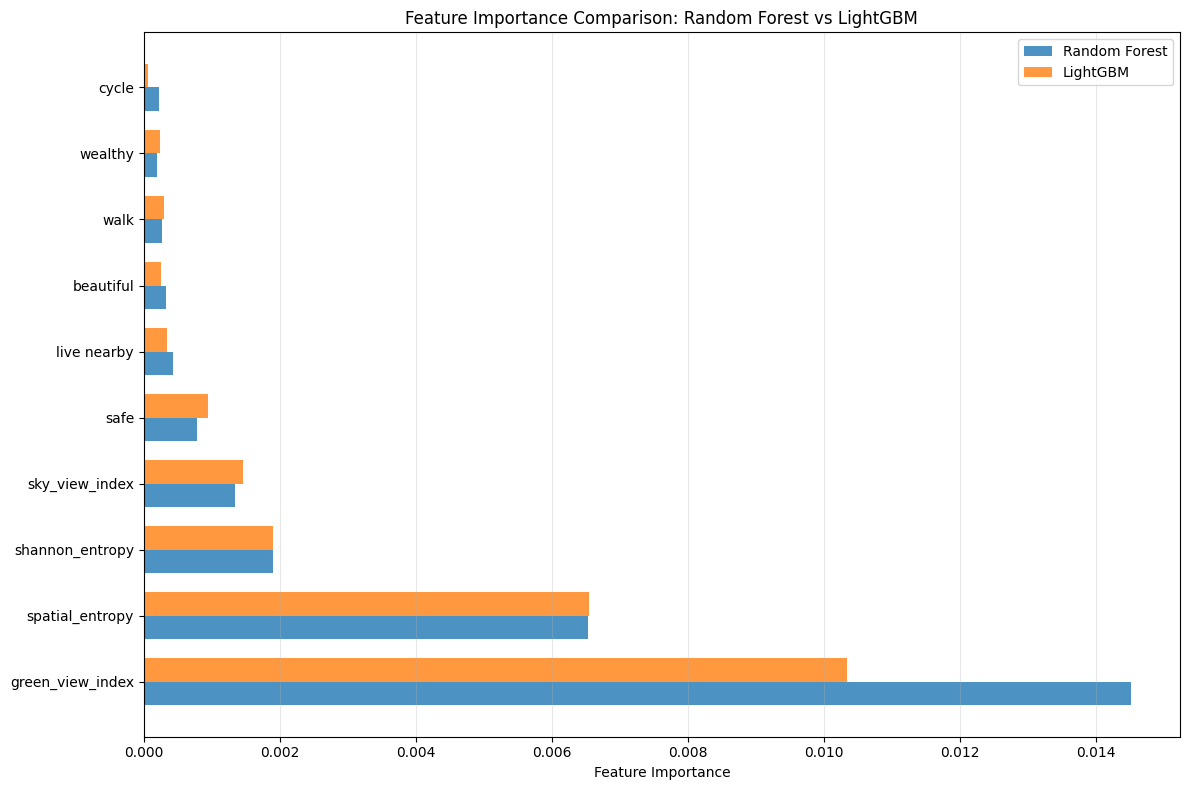

In [23]:
rf_importance = None
lgb_importance = None
feature_comparison = None
    
# Get feature names (handle encoded categorical variables)
feature_names = list(X_train.columns) if hasattr(X_train, 'columns') else [f'feature_{i}' for i in range(X_train.shape[1])]
feature_names = feature_names.remove('svi_from')       

# Random Forest importance
rf_importance = analyze_conditional_feature_importance(best_rf, X_train, X_test, y_test, "Random Forest", feature_names)
plot_feature_importance(rf_importance, "Random Forest")
# save results
rf_importance['conditional_permutation'].to_csv('data/model/rf_conditional_permutation_importance.csv', index=False)

# LightGBM importance  
lgb_importance = analyze_conditional_feature_importance(best_lgb, X_train, X_test, y_test, "LightGBM", feature_names)
plot_feature_importance(lgb_importance, "LightGBM")
lgb_importance['conditional_permutation'].to_csv('data/model/lgb_conditional_permutation_importance.csv', index=False)

# Compare across models
results_for_comparison = {
'rf_importance': rf_importance,
'lgb_importance': lgb_importance
}

feature_comparison = compare_feature_importance_across_models(results_for_comparison)


In [24]:
rf_importance

{'builtin':               feature  importance
 11   green_view_index    0.338527
 12    spatial_entropy    0.124822
 13    shannon_entropy    0.057890
 7                safe    0.052097
 10     sky_view_index    0.051980
 5         live nearby    0.048439
 9             wealthy    0.048249
 1           beautiful    0.047199
 8                walk    0.046792
 3               cycle    0.045015
 6              lively    0.043743
 4          depressing    0.042916
 2              boring    0.039807
 0   participants_from    0.012526,
 'permutation':               feature  importance_mean  importance_std
 11   green_view_index         0.014506        0.001209
 12    spatial_entropy         0.006526        0.000815
 13    shannon_entropy         0.001905        0.000333
 10     sky_view_index         0.001337        0.000129
 7                safe         0.000784        0.000258
 5         live nearby         0.000422        0.000163
 1           beautiful         0.000327        0.000147


In [25]:
lgb_importance

{'builtin':               feature  importance
 7                safe         961
 5         live nearby         943
 11   green_view_index         941
 10     sky_view_index         936
 9             wealthy         919
 1           beautiful         912
 12    spatial_entropy         889
 6              lively         883
 13    shannon_entropy         866
 3               cycle         811
 8                walk         789
 4          depressing         710
 2              boring         691
 0   participants_from         260,
 'permutation':               feature  importance_mean  importance_std
 11   green_view_index         0.010333        0.001171
 12    spatial_entropy         0.006543        0.000683
 13    shannon_entropy         0.001900        0.000262
 10     sky_view_index         0.001457        0.000143
 7                safe         0.000940        0.000317
 5         live nearby         0.000333        0.000160
 8                walk         0.000300        0.000117
